
Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM_3yr.pt
[LSTM] Epoch 100/1500, Training Loss: 0.000007, Validation Loss: 0.052186
[LSTM] Epoch 200/1500, Training Loss: 0.000008, Validation Loss: 0.055212
[LSTM] Epoch 300/1500, Training Loss: 0.000017, Validation Loss: 0.037138
[LSTM] Epoch 400/1500, Training Loss: 0.000020, Validation Loss: 0.032013
Early stopping triggered
[LSTM] Early stopping at epoch 490
[LSTM] Test Loss: 0.062604
[LSTM] Test MAPE: 41.22%
[LSTM] Test Accuracy: 58.78%

Training GRU model...
Loaded existing model for GRU from best_model_GRU_3yr.pt
[GRU] Epoch 100/1500, Training Loss: 0.000018, Validation Loss: 0.007380
Early stopping triggered
[GRU] Early stopping at epoch 156
[GRU] Test Loss: 0.051905
[GRU] Test MAPE: 37.60%
[GRU] Test Accuracy: 62.40%

Training RNN model...
Loaded existing model for RNN from best_model_RNN_3yr.pt
[RNN] Epoch 100/1500, Training Loss: 0.000022, Validation Loss: 0.002898
[RNN] Epoch 200/1500, Training Loss: 

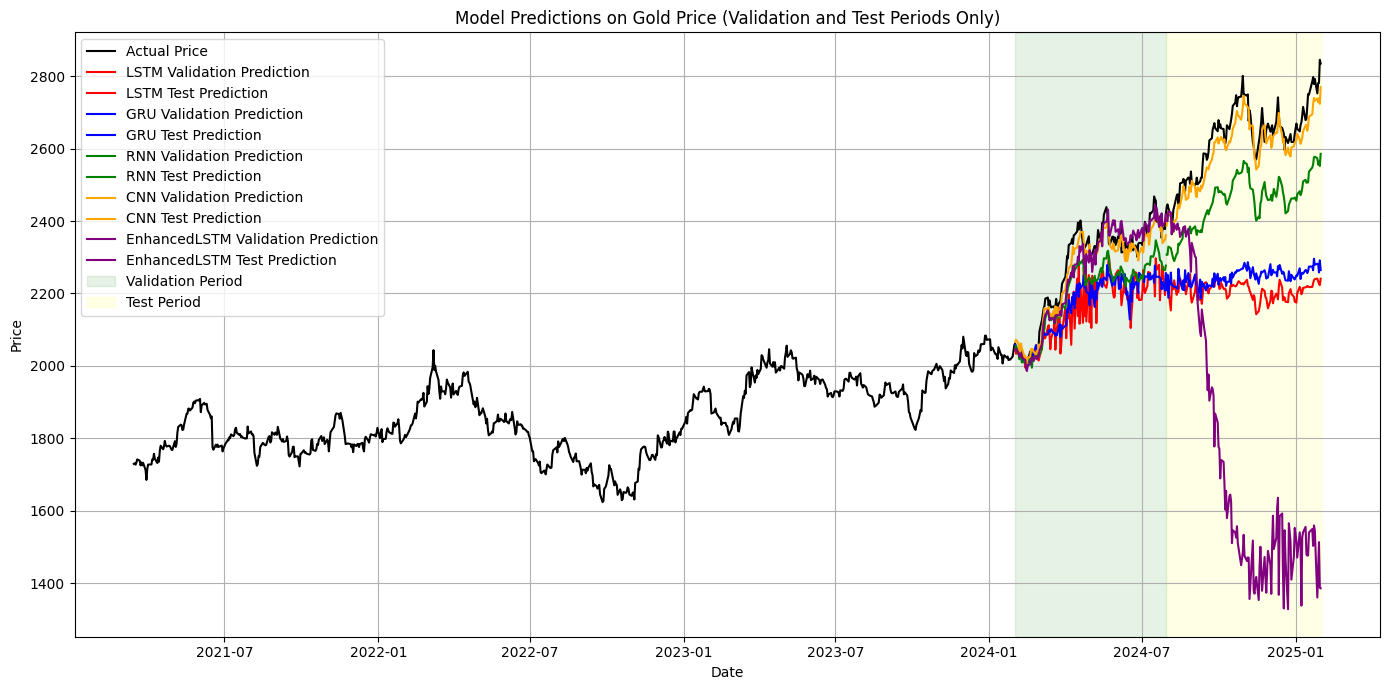

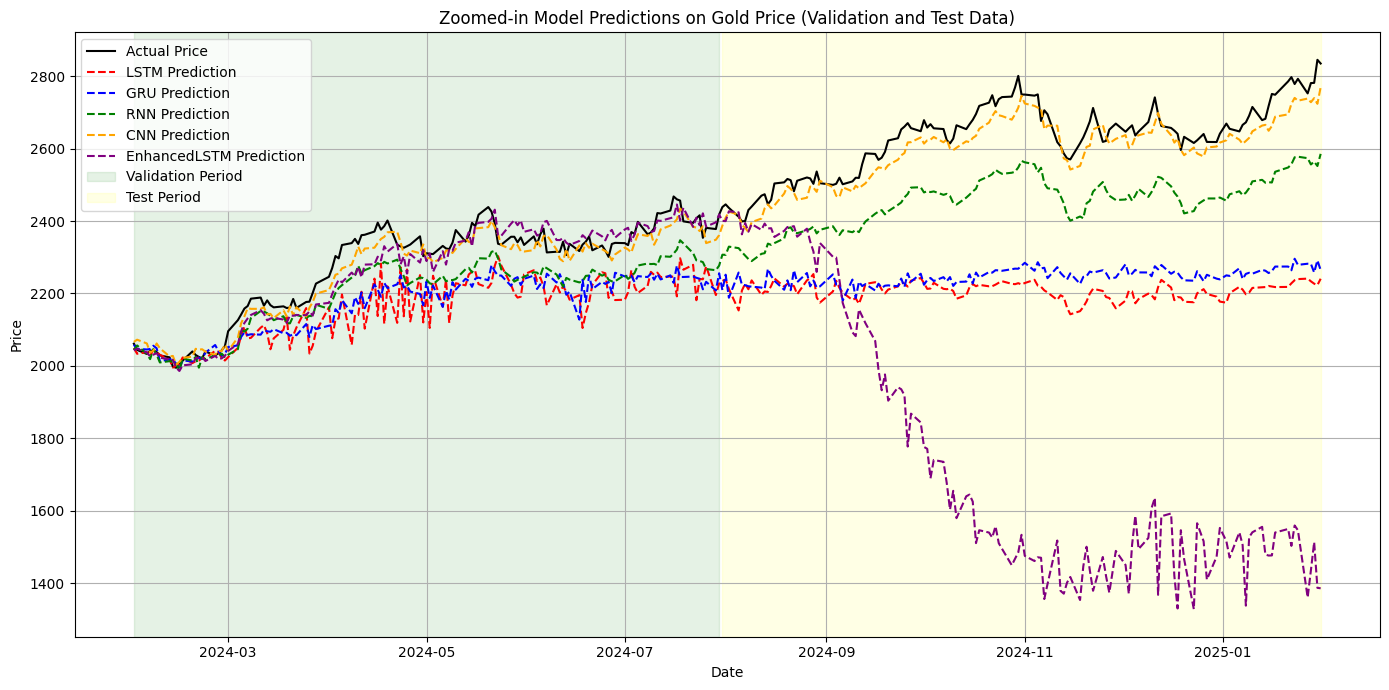

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

### Window width ### Could be adjusted for experimentation ###
window_width = 30  # 30 days


# Prepare sequences and corresponding dates
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# Split the data into training, validation, and test sets based on dates
train_mask = dates < pd.to_datetime('2024-02-01') 
val_mask = (dates >= pd.to_datetime('2024-02-01')) & (dates < pd.to_datetime('2024-07-31'))
test_mask = dates >= pd.to_datetime('2024-07-31')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle=False for sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### All the above are the data cleaning and preparation steps ### 


# Define the models
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate the output size after Conv1d layers
            # Each Conv1d layer reduces the sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2 * (3 - 1)  # Two Conv1d layers with kernel_size=3
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, channels, seq_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# Function to train and evaluate a model
def train_and_evaluate(model_name):
    # Initialize the model
    model = BaseModel(model_type=model_name).to(device)
    
    # Define the criterion, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500 # Adjusted number of epochs
    best_val_loss = float('inf')
    
    # Lists to store loss history
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    # Path to save the best model checkpoint
    best_model_path = f'best_model_{model_name}_3yr.pt'
    
    # Check if a saved model exists and load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        # Scheduler step
        scheduler.step(avg_val_loss)
        
        # Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        # Print losses every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    
    # Evaluate on test data
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    # Concatenate test predictions
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    
    # Calculate MAPE and accuracy
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # Collect predictions over validation and test sets
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    y_test_pred = y_test_pred_array
    
    # Inverse scaling
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred)
    
    # Store results
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    
    return results

# List of models to train
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Dictionary to store results
all_results = {}
    
# Train and evaluate each model
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual validation and test target values
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

# Actual Price
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

# Plot predicted data for each model over validation and test datasets only
for model_name, results in all_results.items():
    # Plot validation predictions
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )
    # Plot test predictions
    plt.plot(
        results['test_dates'],
        results['y_test_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Test Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Model Predictions on Gold Price (Validation and Test Periods Only)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in plot for validation and test data with dashed lines for models
plt.figure(figsize=(14, 7))

# Combine validation and test dates and actual prices
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual prices for validation and test periods
plt.plot(
    zoom_dates,
    zoom_actual,
    color='black',
    label='Actual Price'
)

# Plot predicted data for each model during validation and test periods with dashed lines
for model_name, results in all_results.items():
    # Combine validation and test predictions
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((results['val_dates'], results['test_dates']))
    plt.plot(
        model_dates,
        y_pred_combined,
        color=model_colors[model_name],
        linestyle='--',  # Dashed lines
        label=f'{model_name} Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation and Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/tmp/ipykernel_1169885/178358117.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))
/tmp/ipykernel_

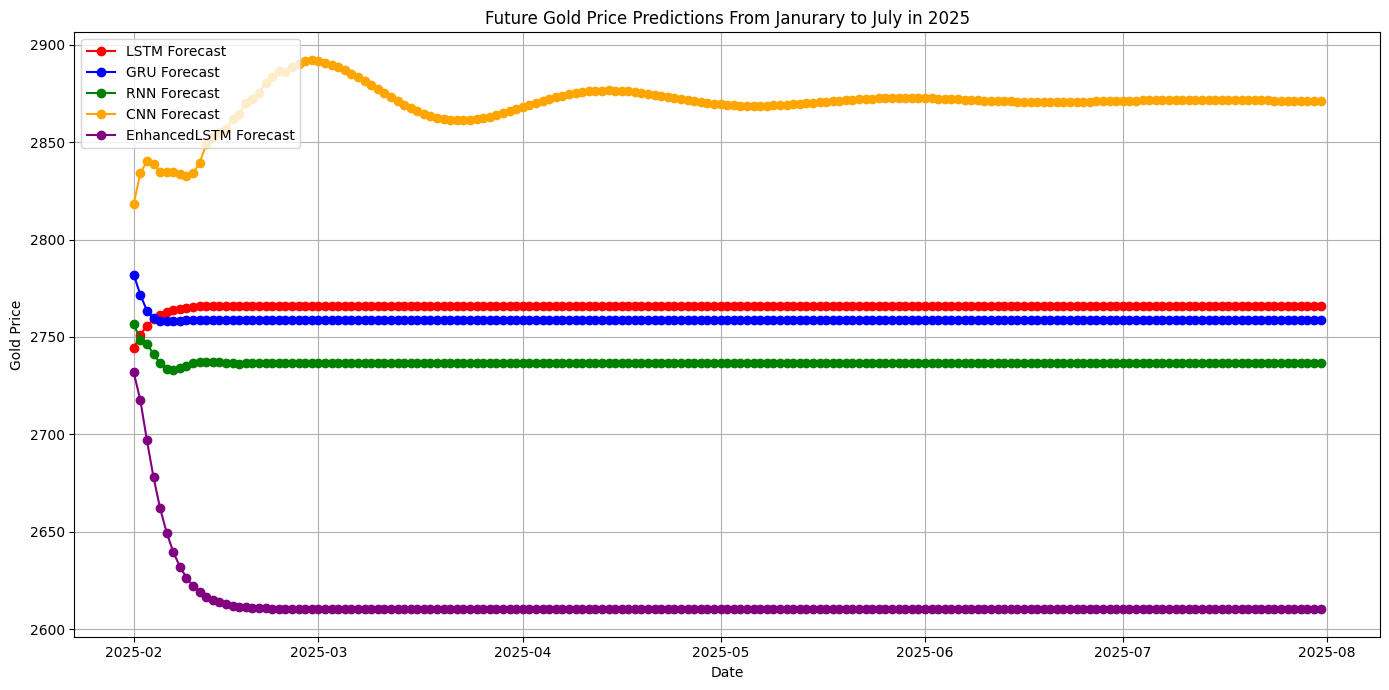

In [18]:
###############################################
# Future Prediction: Forecasting Gold Price
# for the period 2019-01-01 to 2019-01-31
###############################################

# Dictionary to store the forecasted prices (in original scale) for each model
future_forecasts = {}

# Define the forecast period: January 1 to January 31, 2019
future_dates = pd.date_range(start='2025-02-01', end='2025-07-31', freq='D')

# For each model, load the saved best checkpoint and perform iterative forecasting
for model_name in model_names:
    # Initialize the model and load the best saved weights
    model = BaseModel(model_type=model_name).to(device)
    best_model_path = f'best_model_{model_name}.pt'
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    
    # Start with the last available window from the entire historical dataset
    # (Make a copy so that the original data_scaled remains unchanged)
    forecast_window = data_scaled[-window_width:].copy()  # shape: (window_width, n_features)
    
    # List to store the scaled predictions (for the target 'Price')
    forecast_preds = []
    
    # Disable gradient tracking for forecasting
    with torch.no_grad():
        # Iterate for each day in the forecast period (31 days)
        for _ in range(len(future_dates)):
            # Prepare the input: add batch dimension (shape: [1, window_width, n_features])
            input_tensor = torch.from_numpy(forecast_window).unsqueeze(0).float().to(device)
            
            # Obtain the prediction (scaled price)
            pred = model(input_tensor)
            pred_value = pred.item()  # scalar value
            
            # Append the predicted scaled price to our list
            forecast_preds.append(pred_value)
            
            # Update the forecast window:
            # Create a new row based on the last row of the current window.
            # Replace only the 'Price' column (index 0) with the predicted value.
            new_row = forecast_window[-1].copy()
            new_row[0] = pred_value
            # Roll the window: remove the oldest row and append the new row at the end
            forecast_window = np.vstack((forecast_window[1:], new_row))
    
    # Inverse transform the list of scaled predictions back to the original scale.
    # (The inverse_transform function only uses the first column, so it works for our list.)
    forecast_preds_inv = inverse_transform(forecast_preds)
    
    # Store the forecasted prices for this model
    future_forecasts[model_name] = forecast_preds_inv

# Plot the future forecasted prices for each model
plt.figure(figsize=(14, 7))
for model_name, preds in future_forecasts.items():
    plt.plot(future_dates, preds, color=model_colors[model_name], linestyle='-', marker='o',
             label=f'{model_name} Forecast')

plt.title('Future Gold Price Predictions From Janurary to July in 2025')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Early stopping triggered!
Validation MAPE (Walk-forward): 3.62%
Test MAPE (Walk-forward):       10.10%


/tmp/ipykernel_1169885/3642842886.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


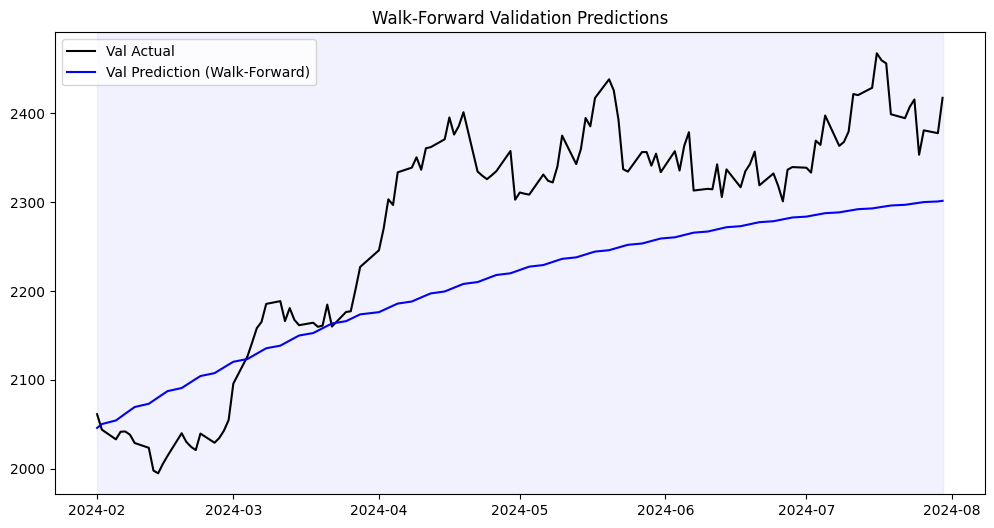

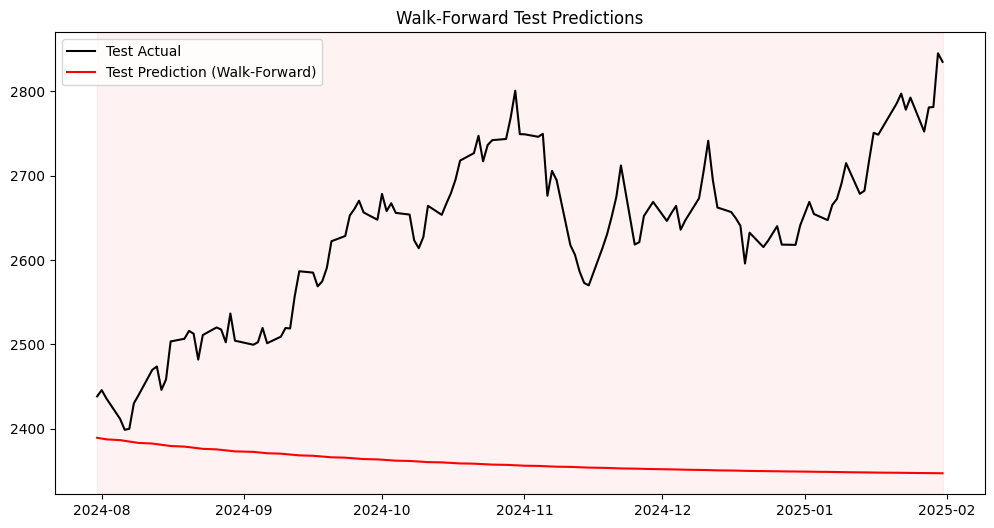

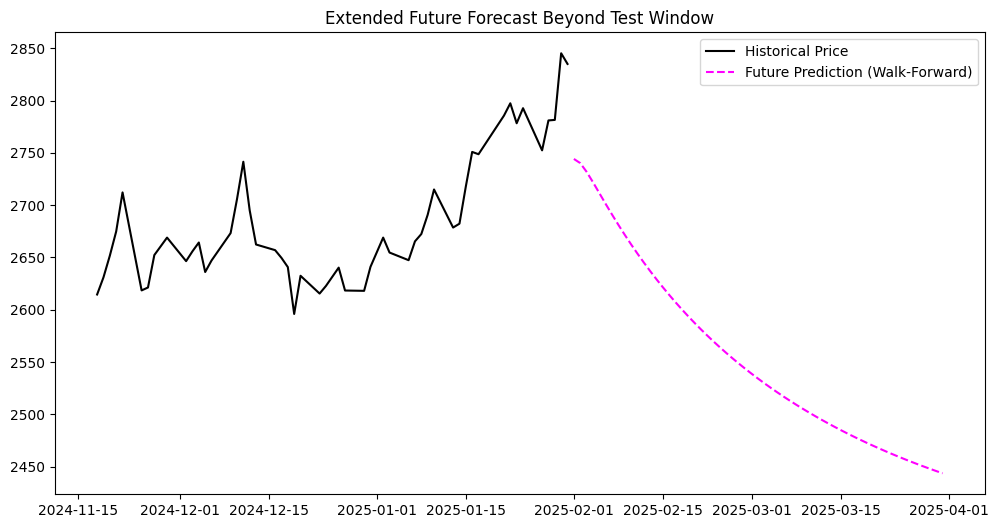

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import os
import random
import warnings

# -----------------------------
# 1) Reproducibility / Settings
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# 2) Data Loading & Preprocessing
# -----------------------------
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')  # Update your filename
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert numeric columns
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')

# Check for duplicates or nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

features = ['Price','Open','High','Low']
data = df[features].values

# Scale features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

window_size = 30  # 30 days

# -----------------------------
# 3) Create rolling windows
# -----------------------------
X_all = []
Y_all = []
dates_all = []

for i in range(window_size, len(data_scaled)):
    X_all.append(data_scaled[i - window_size : i])   # shape (30, 4)
    Y_all.append(data_scaled[i, 0])                  # 'Price' is index=0 in 'features'
    dates_all.append(df['Date'].iloc[i])

X_all = np.array(X_all)  # shape (N, 30, 4)
Y_all = np.array(Y_all)  # shape (N,)
dates_all = np.array(dates_all)

# -----------------------------
# 4) Train/Val/Test Split by Date
# -----------------------------
train_cutoff = pd.to_datetime('2024-02-01')
val_cutoff   = pd.to_datetime('2024-07-31')

train_mask = dates_all < train_cutoff
val_mask   = (dates_all >= train_cutoff) & (dates_all < val_cutoff)
test_mask  = dates_all >= val_cutoff

X_train, Y_train, train_dates = X_all[train_mask], Y_all[train_mask], dates_all[train_mask]
X_val,   Y_val,   val_dates   = X_all[val_mask],   Y_all[val_mask],   dates_all[val_mask]
X_test,  Y_test,  test_dates  = X_all[test_mask],  Y_all[test_mask],  dates_all[test_mask]

# Convert to Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32).unsqueeze(1)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val_t,   Y_val_t),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  Y_test_t),  batch_size=batch_size, shuffle=False)

# -----------------------------
# 5) Define Model
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last timestep
        out = self.fc(out)
        return out

# -----------------------------
# 6) Simple EarlyStopping
# -----------------------------
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# -----------------------------
# 7) Inverse Transform Function
# -----------------------------
def inverse_price_transform(scaled_prices):
    """
    Scaled_prices: shape (N,) or (N,1).
    We'll fill placeholders for other 3 features to use the same scaler.
    """
    # Ensure shape (N,1)
    scaled_prices = scaled_prices.reshape(-1, 1)
    
    # Create placeholders for other 3 features: zeros
    zeros = np.zeros((scaled_prices.shape[0], len(features) - 1))
    combined = np.hstack([scaled_prices, zeros])  # shape (N,4)
    inv = scaler.inverse_transform(combined)
    return inv[:, 0]  # Return the first column (Price)

# -----------------------------
# 8) Train the Model
# -----------------------------
model = LSTMModel().to(device)
criterion = nn.HuberLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=30)

epochs = 300
early_stopping = EarlyStopping(patience=30, min_delta=0.0)
best_val_loss = float('inf')
best_model_path = 'best_lstm_walk_forward.pt'

for epoch in range(epochs):
    # ---- Training ----
    model.train()
    train_losses = []
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    # ---- Validation ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            preds = model(Xb)
            loss = criterion(preds, Yb)
            val_losses.append(loss.item())
    avg_val_loss = np.mean(val_losses)
    
    # Scheduler + EarlyStopping
    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        break
    
    # Save best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device))


# ----------------------------------------------------------
# 9) Walk-Forward Forecasting in Validation and Test Windows
# ----------------------------------------------------------
def walk_forward_forecast(model, data_scaled, dates, start_idx, end_idx, window=30):
    """
    data_scaled: shape (N, 4) - entire scaled dataset for features.
    dates:       shape (N,)   - array of pd.Timestamps matching data_scaled.
    start_idx:   integer index in [0..N) where we begin the walk-forward
    end_idx:     integer index in [0..N) where we end the walk-forward (exclusive)
    window:      how many past days form each input.
    
    Returns:
      predictions_scaled: shape (end_idx - start_idx,)
      actual_scaled:      shape (end_idx - start_idx,) (for comparison)
      pred_dates:         corresponding timestamps
    """
    model.eval()
    
    # We'll collect predicted and actual scaled values for day t in [start_idx, end_idx).
    predictions_scaled = []
    actual_scaled = []
    pred_dates = []
    
    # Start with the last 'window' actual data points *before* start_idx
    # This chunk of data is real historical data used as the initial window.
    current_window = data_scaled[start_idx - window : start_idx].copy()  # shape(30,4)
    
    # We'll proceed day by day. For each day 't' in [start_idx..end_idx-1]:
    #   - The model uses current_window for input
    #   - Predict day t
    #   - Compare with actual day t (for error if t < len(dates))
    #   - Then SHIFT the window to drop the oldest day and add the predicted day (or actual day if you prefer).
    # 
    # In "pure predictions" mode, we feed the predicted Price as day t's first feature
    # and either guess or replicate that Price for the other 3 features if we do not have them.
    
    for t in range(start_idx, end_idx):
        # Prepare input (batch_size=1, seq_len=30, input_size=4)
        inp = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Make prediction for day t
        with torch.no_grad():
            pred = model(inp)  # shape (1,1)
        pred_val = pred.cpu().numpy().flatten()[0]  # scaled price
        
        # Store the model's scaled prediction
        predictions_scaled.append(pred_val)
        pred_dates.append(dates[t])
        
        # Also store the actual scaled price for day t if it exists in data
        actual_scaled.append(data_scaled[t, 0])  # day t, Price is index=0
        
        # SHIFT the window forward by 1 day:
        # drop the oldest day and append the new predicted day at the end
        current_window = current_window[1:]  # shape(29,4)
        
        # The next line is how we fill in the new day. 
        # If you do not have future 'Open, High, Low', you might replicate pred_val for all 4 features:
        next_day_features = np.array([pred_val]*4)  
        # If you have a separate approach for 'Open,High,Low', do that here.
        
        # Append to current_window
        current_window = np.vstack([current_window, next_day_features])
    
    return np.array(predictions_scaled), np.array(actual_scaled), np.array(pred_dates)

# Get the overall scaled dataset and date array
data_scaled_full = data_scaled  # shape(N,4)
dates_full = df['Date'].values  # shape(N,)

# Indices that match X_all, Y_all
# Because X_all starts from index=30 in the raw data, we must offset properly.
# For convenience, we can just forecast from day=window_size up to len(data).
N = len(data_scaled_full)

# Identify the val/test indices in the raw data 
# We find the *first day* that belongs to the val_mask in X_all, etc.
val_start_idx = np.where(dates_full == val_dates[0])[0][0]   # e.g., the first validation day in original df
val_end_idx   = np.where(dates_full == val_dates[-1])[0][0] + 1
test_start_idx= np.where(dates_full == test_dates[0])[0][0]
test_end_idx  = np.where(dates_full == test_dates[-1])[0][0] + 1

# --- Walk-forward for Validation ---
val_preds_scaled, val_actual_scaled, val_pred_dates = walk_forward_forecast(
    model, data_scaled_full, dates_full, val_start_idx, val_end_idx, window=window_size
)

# --- Walk-forward for Test ---
test_preds_scaled, test_actual_scaled, test_pred_dates = walk_forward_forecast(
    model, data_scaled_full, dates_full, test_start_idx, test_end_idx, window=window_size
)

# Inverse transform
val_preds_inv = inverse_price_transform(val_preds_scaled)
val_actual_inv= inverse_price_transform(val_actual_scaled)
test_preds_inv= inverse_price_transform(test_preds_scaled)
test_actual_inv= inverse_price_transform(test_actual_scaled)

# Metrics
val_mape = mean_absolute_percentage_error(val_actual_inv, val_preds_inv)*100
test_mape= mean_absolute_percentage_error(test_actual_inv, test_preds_inv)*100
print(f"Validation MAPE (Walk-forward): {val_mape:.2f}%")
print(f"Test MAPE (Walk-forward):       {test_mape:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.plot(val_pred_dates, val_actual_inv, label='Val Actual', color='black')
plt.plot(val_pred_dates, val_preds_inv, label='Val Prediction (Walk-Forward)', color='blue')
plt.axvspan(val_pred_dates.min(), val_pred_dates.max(), color='blue', alpha=0.05)
plt.title("Walk-Forward Validation Predictions")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_pred_dates, test_actual_inv, label='Test Actual', color='black')
plt.plot(test_pred_dates, test_preds_inv, label='Test Prediction (Walk-Forward)', color='red')
plt.axvspan(test_pred_dates.min(), test_pred_dates.max(), color='red', alpha=0.05)
plt.title("Walk-Forward Test Predictions")
plt.legend()
plt.show()


# ----------------------------------------------------------
# 10) Optional: True Future Prediction Beyond Test Window
# ----------------------------------------------------------
# Suppose your last available date in df is 2025-01-31. 
# We'll pretend we want to forecast from 2025-02-01 to 2025-03-31 purely using the model's prior predictions.

future_start_date = pd.to_datetime('2025-02-01')
future_end_date   = pd.to_datetime('2025-03-31')
all_dates = df['Date'].sort_values().unique()

# Get the index of the last known date (the final day in your dataset)
final_known_date = all_dates[-1]
final_known_idx  = np.where(dates_full == final_known_date)[0][0]  # integer index

# Generate a new date range
future_dates = pd.date_range(future_start_date, future_end_date, freq='D')
# We'll walk-forward from final_known_idx+1 up to final_known_idx + len(future_dates).
# But we must keep a dummy array for "data_scaled_full" extending into the future. 
# For multi-feature approaches, you'd have to guess future 'Open,High,Low'.

# Create a temporary "extended" data array. 
# We'll fill it with the last known row for convenience, then override the Price with model predictions as we go.
num_future_days = len(future_dates)
extended_data_scaled = np.vstack([data_scaled_full, np.tile(data_scaled_full[-1], (num_future_days,1))])

def walk_forward_future(model, data_scaled, start_idx, steps, window=30):
    """ Walk-forward from start_idx for 'steps' days, using predicted values for all features. """
    current_window = data_scaled[start_idx - window : start_idx].copy()
    predictions = []
    for i in range(steps):
        inp = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(inp)
        pred_val = pred.cpu().numpy().flatten()[0]  # scaled Price
        predictions.append(pred_val)
        
        # SHIFT window: drop oldest row, append new predicted row
        current_window = current_window[1:]
        # replicate the predicted Price across all 4 features if you have no separate approach:
        next_day_features = np.array([pred_val]*4)
        current_window = np.vstack([current_window, next_day_features])
        # also store it back into data_scaled if you want continuity
        data_scaled[start_idx + i] = next_day_features
    return np.array(predictions)

# starting index for future: final_known_idx + 1
future_preds_scaled = walk_forward_future(
    model,
    extended_data_scaled,
    start_idx=final_known_idx + 1,
    steps=num_future_days,
    window=window_size
)

future_preds_inv = inverse_price_transform(future_preds_scaled)

plt.figure(figsize=(12,6))
# plot last portion of actual
cut_idx = max(0, final_known_idx - 50)  # show last 50 days of actual
plt.plot(all_dates[cut_idx:], inverse_price_transform(data_scaled_full[cut_idx:,0]), label='Historical Price', color='black')

# append future predictions
plt.plot(future_dates, future_preds_inv, label='Future Prediction (Walk-Forward)', color='magenta', linestyle='--')

plt.title("Extended Future Forecast Beyond Test Window")
plt.legend()
plt.show()


Early stopping triggered!


/tmp/ipykernel_1169885/3234447238.py:207: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


Validation MAPE (Walk-Forward w/ Updates): 9.25%
Test MAPE (Walk-Forward w/ Updates): 3.79%


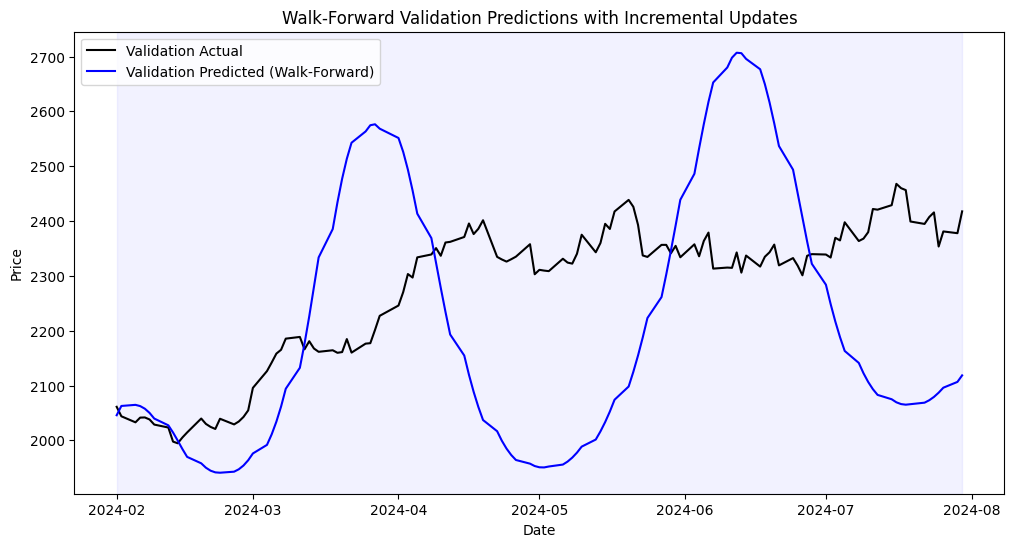

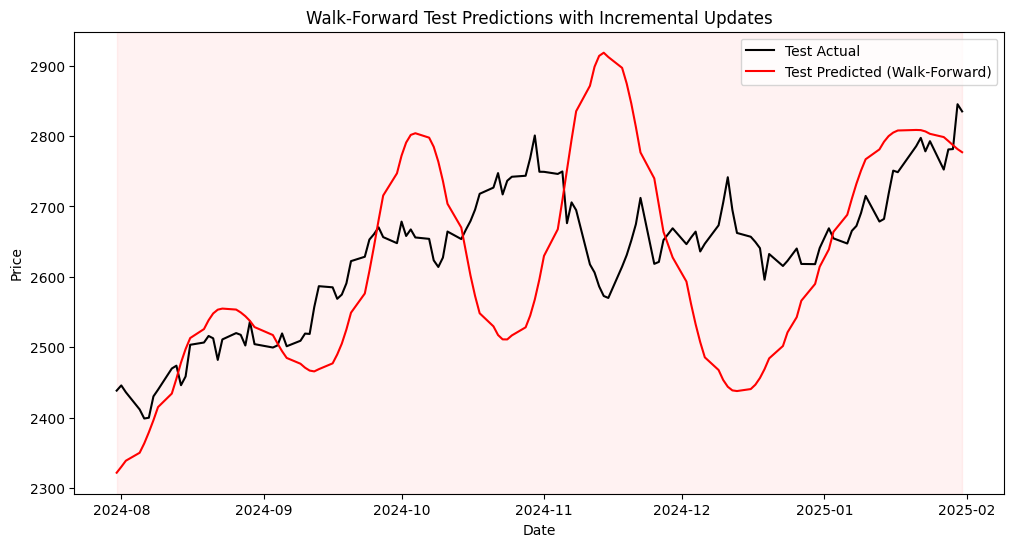

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import os
import random
import warnings

# -----------------------------
# 1) Reproducibility & Settings
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# 2) Data Loading & Preprocessing
# -----------------------------
# Change the filename as needed.
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert numeric columns (remove commas and convert to float)
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')

# Check for duplicates or nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Define features (we use 4: Price, Open, High, Low)
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale all features between 0 and 1.
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

window_size = 30  # number of days for each input window

# -----------------------------
# 3) Create Rolling Windows (for training purposes)
# -----------------------------
X_all = []
Y_all = []
dates_all = []

# Each X window has shape (30,4) and target is next day's Price (index 0)
for i in range(window_size, len(data_scaled)):
    X_all.append(data_scaled[i - window_size : i])
    Y_all.append(data_scaled[i, 0])
    dates_all.append(df['Date'].iloc[i])

X_all = np.array(X_all)  # shape (N, 30, 4)
Y_all = np.array(Y_all)  # shape (N,)
dates_all = np.array(dates_all)

# -----------------------------
# 4) Train/Validation/Test Split by Date
# -----------------------------
# Define cutoffs (adjust as needed)
train_cutoff = pd.to_datetime('2024-02-01')
val_cutoff   = pd.to_datetime('2024-07-31')

train_mask = dates_all < train_cutoff
val_mask   = (dates_all >= train_cutoff) & (dates_all < val_cutoff)
test_mask  = dates_all >= val_cutoff

X_train, Y_train, train_dates = X_all[train_mask], Y_all[train_mask], dates_all[train_mask]
X_val,   Y_val,   val_dates   = X_all[val_mask],   Y_all[val_mask],   dates_all[val_mask]
X_test,  Y_test,  test_dates  = X_all[test_mask],  Y_all[test_mask],  dates_all[test_mask]

# Convert training data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val_t, Y_val_t), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=batch_size, shuffle=False)

# -----------------------------
# 5) Define the LSTM Model
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the output at the last time step
        out = self.fc(out)
        return out

# -----------------------------
# 6) Define a Simple Early Stopping Mechanism
# -----------------------------
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# -----------------------------
# 7) Define an Inverse Transformation Function for Price
# -----------------------------
def inverse_price_transform(scaled_prices):
    """
    scaled_prices: numpy array of shape (N,) or (N,1)
    To inverse-transform Price, we create a dummy array for the other 3 features.
    """
    scaled_prices = scaled_prices.reshape(-1, 1)
    # Create dummy placeholders for the other features (zeros)
    zeros = np.zeros((scaled_prices.shape[0], len(features) - 1))
    combined = np.hstack([scaled_prices, zeros])  # shape (N,4)
    inv = scaler.inverse_transform(combined)
    return inv[:, 0]  # return only the Price

# -----------------------------
# 8) Train the Model (One-Step-Ahead Training)
# -----------------------------
model = LSTMModel().to(device)
criterion = nn.HuberLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=30)

epochs = 300
early_stopping = EarlyStopping(patience=30, min_delta=0.0)
best_val_loss = float('inf')
best_model_path = 'best_lstm_walk_forward.pt'

for epoch in range(epochs):
    model.train()
    train_losses = []
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            preds = model(Xb)
            loss = criterion(preds, Yb)
            val_losses.append(loss.item())
    avg_val_loss = np.mean(val_losses)
    
    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        break
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

# Load the best model from training
model.load_state_dict(torch.load(best_model_path, map_location=device))

# -----------------------------
# 9) Walk-Forward Forecasting with Incremental Updates
# -----------------------------
def walk_forward_with_updates(model, data_scaled, dates, start_idx, end_idx, window=30, epochs_per_update=1, lr=1e-4):
    """
    Walk-forward forecast from start_idx to end_idx - 1 using only model predictions
    for inputs. After predicting day t, update the model with the actual day t price.
    
    Args:
      model: Trained LSTM model.
      data_scaled: Entire scaled dataset (shape: (N, 4)). The 0th column is Price.
      dates: Array of pd.Timestamp corresponding to rows of data_scaled.
      start_idx: Integer index in data_scaled where walk-forward begins.
      end_idx:   Integer index (exclusive) where walk-forward ends.
      window:    Number of days in each input window.
      epochs_per_update: Number of training epochs (mini-steps) after receiving actual data.
      lr:        Learning rate for the incremental updates.
      
    Returns:
      preds_scaled: numpy array of predictions (scaled Price) for days in [start_idx, end_idx).
      actual_scaled: numpy array of actual scaled Price for these days.
      forecast_dates: numpy array of corresponding timestamps.
    """
    # Create a separate optimizer for incremental updates.
    inc_optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    model.eval()
    
    preds_scaled = []
    actual_scaled = []
    forecast_dates = []
    
    # Initialize current window using the last 'window' days of real data before start_idx.
    current_window = data_scaled[start_idx - window : start_idx].copy()  # shape (window, 4)
    
    for t in range(start_idx, end_idx):
        # 1) Predict day t using current_window (pure prediction; no actual data is fed in)
        X_in = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)  # shape (1, window, 4)
        with torch.no_grad():
            y_pred_t = model(X_in).cpu().numpy().flatten()[0]  # scaled Price prediction
        preds_scaled.append(y_pred_t)
        forecast_dates.append(dates[t])
        
        # 2) Record the actual scaled Price for day t (0th column)
        y_true_t = data_scaled[t, 0]
        actual_scaled.append(y_true_t)
        
        # 3) Shift the window forward:
        # Remove the oldest day and append the predicted day.
        current_window = current_window[1:]  # drop the oldest row
        # If you have no extra info for Open, High, Low, replicate predicted Price.
        next_day_features = np.array([y_pred_t] * 4)
        current_window = np.vstack([current_window, next_day_features])
        
        # 4) After the prediction, assume day t has now "closed" and actual data is available.
        # Perform a small incremental update on the model with the new (X, y) pair.
        # We construct an update example: input = the window that produced y_pred, target = actual y_true.
        X_update = X_in  # same as used for prediction (shape: (1, window, 4))
        Y_update = torch.tensor([y_true_t], dtype=torch.float32).unsqueeze(1).to(device)  # shape: (1,1)
        
        model.train()
        for _ in range(epochs_per_update):
            inc_optimizer.zero_grad()
            y_update_pred = model(X_update)
            update_loss = loss_fn(y_update_pred, Y_update)
            update_loss.backward()
            inc_optimizer.step()
        model.eval()
    
    return np.array(preds_scaled), np.array(actual_scaled), np.array(forecast_dates)

# -----------------------------
# 10) Apply Walk-Forward with Updates on Validation & Test Sets
# -----------------------------
# For these routines, we need the full scaled dataset and date array.
data_scaled_full = data_scaled   # shape (N, 4)
dates_full = df['Date'].values    # shape (N,)

# Find indices in the full data corresponding to the start/end of validation/test.
val_start_idx = np.where(dates_full == val_dates[0])[0][0]
val_end_idx   = np.where(dates_full == val_dates[-1])[0][0] + 1
test_start_idx = np.where(dates_full == test_dates[0])[0][0]
test_end_idx   = np.where(dates_full == test_dates[-1])[0][0] + 1

# Walk-forward forecasting on the Validation window (pure predictions with incremental updates)
val_preds_scaled, val_actual_scaled, val_forecast_dates = walk_forward_with_updates(
    model, data_scaled_full, dates_full,
    start_idx=val_start_idx,
    end_idx=val_end_idx,
    window=window_size,
    epochs_per_update=1,    # adjust as desired
    lr=1e-4
)

# Walk-forward forecasting on the Test window (pure predictions with incremental updates)
test_preds_scaled, test_actual_scaled, test_forecast_dates = walk_forward_with_updates(
    model, data_scaled_full, dates_full,
    start_idx=test_start_idx,
    end_idx=test_end_idx,
    window=window_size,
    epochs_per_update=1,
    lr=1e-4
)

# Inverse-transform the predictions and actual prices
val_preds_inv = inverse_price_transform(val_preds_scaled)
val_actual_inv = inverse_price_transform(val_actual_scaled)
test_preds_inv = inverse_price_transform(test_preds_scaled)
test_actual_inv = inverse_price_transform(test_actual_scaled)

# Compute error metrics
val_mape = mean_absolute_percentage_error(val_actual_inv, val_preds_inv) * 100
test_mape = mean_absolute_percentage_error(test_actual_inv, test_preds_inv) * 100
print(f"Validation MAPE (Walk-Forward w/ Updates): {val_mape:.2f}%")
print(f"Test MAPE (Walk-Forward w/ Updates): {test_mape:.2f}%")

# -----------------------------
# 11) Plot the Walk-Forward Forecasts
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(val_forecast_dates, val_actual_inv, label='Validation Actual', color='black')
plt.plot(val_forecast_dates, val_preds_inv, label='Validation Predicted (Walk-Forward)', color='blue')
plt.axvspan(val_forecast_dates.min(), val_forecast_dates.max(), color='blue', alpha=0.05)
plt.title("Walk-Forward Validation Predictions with Incremental Updates")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_forecast_dates, test_actual_inv, label='Test Actual', color='black')
plt.plot(test_forecast_dates, test_preds_inv, label='Test Predicted (Walk-Forward)', color='red')
plt.axvspan(test_forecast_dates.min(), test_forecast_dates.max(), color='red', alpha=0.05)
plt.title("Walk-Forward Test Predictions with Incremental Updates")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


Using device: cuda
======= Training All Models (One-Step-Ahead) =======

Training LSTM...
Early stopping triggered!
LSTM: Early stopping at epoch 48

Training GRU...
[GRU] Epoch 50/300 | Train Loss: 0.000148 | Val Loss: 0.000282
Early stopping triggered!
GRU: Early stopping at epoch 78

Training RNN...
[RNN] Epoch 50/300 | Train Loss: 0.000158 | Val Loss: 0.003806
[RNN] Epoch 100/300 | Train Loss: 0.000167 | Val Loss: 0.002658
[RNN] Epoch 150/300 | Train Loss: 0.000140 | Val Loss: 0.002181
[RNN] Epoch 200/300 | Train Loss: 0.000138 | Val Loss: 0.001824
[RNN] Epoch 250/300 | Train Loss: 0.000122 | Val Loss: 0.000331
Early stopping triggered!
RNN: Early stopping at epoch 288

Training CNN...
[CNN] Epoch 50/300 | Train Loss: 0.000134 | Val Loss: 0.000286
[CNN] Epoch 100/300 | Train Loss: 0.000116 | Val Loss: 0.000405
Early stopping triggered!
CNN: Early stopping at epoch 131

Training EnhancedLSTM...
Early stopping triggered!
EnhancedLSTM: Early stopping at epoch 36

======= Walk-Forward 

/tmp/ipykernel_1169885/3485607353.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


LSTM Validation MAPE: 8.67%
LSTM Test MAPE:       3.41%

--- Model: GRU ---


/tmp/ipykernel_1169885/3485607353.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


GRU Validation MAPE: 8.70%
GRU Test MAPE:       5.23%

--- Model: RNN ---


/tmp/ipykernel_1169885/3485607353.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


RNN Validation MAPE: 7.85%
RNN Test MAPE:       3.49%

--- Model: CNN ---
CNN Validation MAPE: 3.84%


/tmp/ipykernel_1169885/3485607353.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


CNN Test MAPE:       2.52%

--- Model: EnhancedLSTM ---


/tmp/ipykernel_1169885/3485607353.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


EnhancedLSTM Validation MAPE: 16.14%
EnhancedLSTM Test MAPE:       21.70%


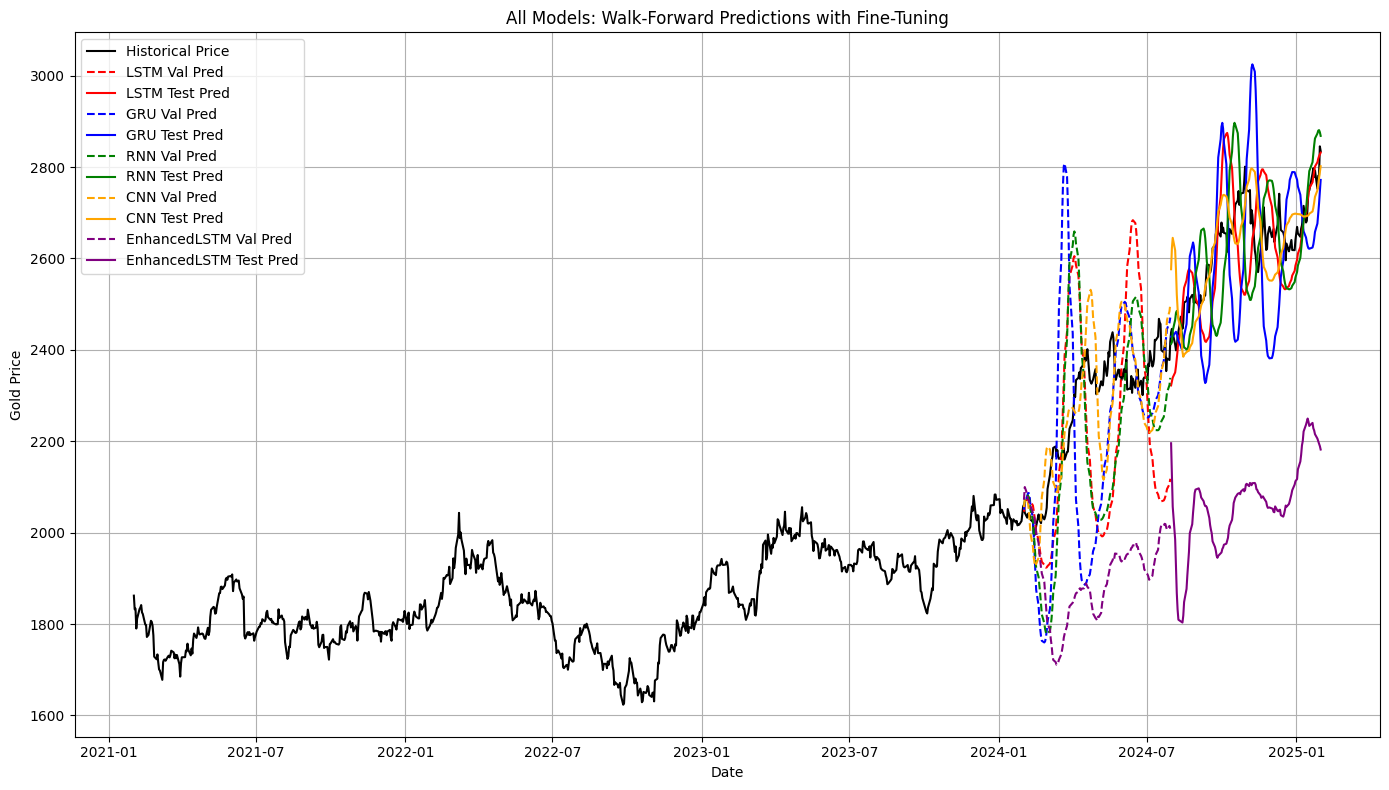

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random
import os
import warnings

# ------------------------------------------------------------------
# 1) Reproducibility & Device Setup
# ------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ------------------------------------------------------------------
# 2) Data Loading & Preprocessing
# ------------------------------------------------------------------
# Update CSV filename as needed
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove commas from numeric fields and convert to float
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')

# Ensure no duplicates or missing values
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to use
features = ['Price','Open','High','Low']
data = df[features].values  # shape (N,4)

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # shape (N,4)

window_size = 30  # rolling window length (days)

# ------------------------------------------------------------------
# 3) Create Rolling Windows (X, y) + Date Array
# ------------------------------------------------------------------
X_all, Y_all, dates_all = [], [], []
for i in range(window_size, len(data_scaled)):
    X_all.append(data_scaled[i - window_size : i])  # shape (30,4)
    Y_all.append(data_scaled[i, 0])  # 'Price' is index 0
    dates_all.append(df['Date'].iloc[i])

X_all = np.array(X_all)     # shape (N, 30, 4)
Y_all = np.array(Y_all)     # shape (N,)
dates_all = np.array(dates_all)

# ------------------------------------------------------------------
# 4) Train / Validation / Test Split by Date
# ------------------------------------------------------------------
train_cutoff = pd.to_datetime('2024-02-01')
val_cutoff   = pd.to_datetime('2024-07-31')

train_mask = dates_all < train_cutoff
val_mask   = (dates_all >= train_cutoff) & (dates_all < val_cutoff)
test_mask  = dates_all >= val_cutoff

X_train, Y_train, train_dates = X_all[train_mask], Y_all[train_mask], dates_all[train_mask]
X_val,   Y_val,   val_dates   = X_all[val_mask],   Y_all[val_mask],   dates_all[val_mask]
X_test,  Y_test,  test_dates  = X_all[test_mask],  Y_all[test_mask],  dates_all[test_mask]

# Convert to torch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32).unsqueeze(1)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val_t,   Y_val_t),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  Y_test_t),  batch_size=batch_size, shuffle=False)

# ------------------------------------------------------------------
# 5) Define Multiple Model Architectures
# ------------------------------------------------------------------
class BaseModel(nn.Module):
    """
    A single class that can instantiate LSTM, GRU, RNN, CNN, or EnhancedLSTM 
    based on 'model_type'.
    """
    def __init__(self, model_type='LSTM', input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity='relu',
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'CNN':
            # For CNN, we use 1D convolutions along the time dimension.
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=hidden_size, kernel_size=3)
            # Each Conv1d with kernel_size=3 reduces length by 2.
            self.conv_output_length = 30 - 2*(3-1)  # = 30 - 4 = 26
            self.fc = nn.Linear(hidden_size * self.conv_output_length, 1)
            
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers+1,  # e.g., one more layer
                batch_first=True,
                dropout=dropout*2
            )
            self.dropout = nn.Dropout(dropout*2)
            self.bn = nn.BatchNorm1d(hidden_size)
            self.fc = nn.Linear(hidden_size, 1)
            
        else:
            raise ValueError("Invalid model_type. Choose from ['LSTM','GRU','RNN','CNN','EnhancedLSTM'].")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            # x: (batch_size, seq_len=30, input_size=4) -> (batch_size, 4, 30)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))  # shape: (batch_size,64,28)
            x = F.relu(self.conv2(x))  # shape: (batch_size, hidden_size, 26)
            x = x.reshape(x.size(0), -1)  # flatten: (batch_size, hidden_size*26)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]         # last time step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# ------------------------------------------------------------------
# 6) Early Stopping
# ------------------------------------------------------------------
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------
# 7) Inverse Transform for Price
# ------------------------------------------------------------------
def inverse_price_transform(scaled_prices):
    """
    scaled_prices: shape (N,) or (N,1).
    Fill placeholders for the other 3 features to use the same scaler.
    """
    scaled_prices = scaled_prices.reshape(-1, 1)
    zeros = np.zeros((scaled_prices.shape[0], len(features)-1))
    combined = np.hstack([scaled_prices, zeros])  # shape (N,4)
    inv = scaler.inverse_transform(combined)
    return inv[:, 0]  # return Price

# ------------------------------------------------------------------
# 8) Training Function for One-Step-Ahead
# ------------------------------------------------------------------
def train_model(model_name, input_size=4):
    """
    Train a model of type 'model_name' on the training set,
    validate on val_loader, with EarlyStopping.
    Returns the path to the saved best checkpoint.
    """
    model = BaseModel(model_type=model_name, input_size=input_size).to(device)
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30)
    early_stopper = EarlyStopping(patience=30, min_delta=0.0)
    
    best_val_loss = float('inf')
    best_path = f"best_model_{model_name}.pt"
    
    epochs = 300
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, Yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                val_preds = model(Xb)
                val_loss = criterion(val_preds, Yb)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        
        scheduler.step(avg_val_loss)
        early_stopper(avg_val_loss)
        if early_stopper.early_stop:
            print(f"{model_name}: Early stopping at epoch {epoch+1}")
            break
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_path)
        
        if (epoch+1) % 50 == 0:
            print(f"[{model_name}] Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    return best_path

# ------------------------------------------------------------------
# 9) Walk-Forward with Fine-Tuning (Incremental Updates)
# ------------------------------------------------------------------
def walk_forward_finetune(model, data_scaled, dates, start_idx, end_idx, window=30, epochs_per_update=1, lr=1e-4):
    """
    Walk-forward forecast from start_idx to end_idx-1:
      - Predict day t using previous (window) days of data (which may be predicted).
      - Once day t's actual price is known, perform a small incremental update.
      - Move to day t+1.
    
    Returns:
      preds_scaled: 1D numpy array of predicted prices (scaled) for days in [start_idx, end_idx)
      actual_scaled: 1D numpy array of actual prices (scaled)
      forecast_dates: numpy array of corresponding timestamps.
    """
    # Set up a small optimizer for incremental updates.
    inc_optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    model.eval()
    
    preds_scaled = []
    actual_scaled = []
    forecast_dates = []
    
    # Start with the last 'window' days (real data) before start_idx.
    current_window = data_scaled[start_idx - window : start_idx].copy()
    
    for t in range(start_idx, end_idx):
        # 1) Pure prediction for day t.
        X_in = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, window, 4)
        with torch.no_grad():
            y_pred_t = model(X_in).cpu().numpy().flatten()[0]
        preds_scaled.append(y_pred_t)
        forecast_dates.append(dates[t])
        
        # 2) Record actual scaled price for day t.
        y_true_t = data_scaled[t, 0]
        actual_scaled.append(y_true_t)
        
        # 3) Shift window forward: remove oldest day, append predicted day's features.
        current_window = current_window[1:]
        next_day_features = np.array([y_pred_t] * 4)
        current_window = np.vstack([current_window, next_day_features])
        
        # 4) Fine-tune with the new actual data.
        # Use the same input X_in and target y_true_t.
        X_update = X_in  # shape: (1, window, 4)
        Y_update = torch.tensor([[y_true_t]], dtype=torch.float32, device=device)  # shape: (1,1)
        
        model.train()
        for _ in range(epochs_per_update):
            inc_optimizer.zero_grad()
            # For EnhancedLSTM (with BatchNorm), replicate X_update to simulate batch size > 1.
            if hasattr(model, 'model_type') and model.model_type == 'EnhancedLSTM':
                X_update_rep = X_update.repeat(2, 1, 1)  # now batch size 2
                Y_update_rep = Y_update.repeat(2, 1)
                out = model(X_update_rep)
                loss = loss_fn(out, Y_update_rep)
            else:
                out = model(X_update)
                loss = loss_fn(out, Y_update)
            loss.backward()
            inc_optimizer.step()
        model.eval()
    
    return np.array(preds_scaled), np.array(actual_scaled), np.array(forecast_dates)

# ------------------------------------------------------------------
# 10) Train All Models & Evaluate with Walk-Forward Fine-Tuning
# ------------------------------------------------------------------
model_types = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
best_paths = {}

print("======= Training All Models (One-Step-Ahead) =======")
for mtype in model_types:
    print(f"\nTraining {mtype}...")
    best_paths[mtype] = train_model(mtype, input_size=4)

# Full scaled data and corresponding date array.
data_scaled_full = data_scaled  # shape (N,4)
dates_full = df['Date'].values   # shape (N,)

# Determine indices for validation and test in the full data.
val_start_idx = np.where(dates_full == val_dates[0])[0][0] if len(val_dates) > 0 else None
val_end_idx   = np.where(dates_full == val_dates[-1])[0][0] + 1 if len(val_dates) > 0 else None
test_start_idx = np.where(dates_full == test_dates[0])[0][0] if len(test_dates) > 0 else None
test_end_idx   = np.where(dates_full == test_dates[-1])[0][0] + 1 if len(test_dates) > 0 else None

results = {}

print("\n======= Walk-Forward Predictions with Fine-Tuning =======")
for mtype in model_types:
    print(f"\n--- Model: {mtype} ---")
    # Load best checkpoint.
    model = BaseModel(model_type=mtype, input_size=4).to(device)
    model.load_state_dict(torch.load(best_paths[mtype], map_location=device))
    
    # Walk-forward on the Validation window.
    if val_start_idx is not None and val_end_idx is not None:
        val_preds_scaled, val_actual_scaled, val_forecast_dates = walk_forward_finetune(
            model,
            data_scaled_full,
            dates_full,
            start_idx=val_start_idx,
            end_idx=val_end_idx,
            window=window_size,
            epochs_per_update=1,
            lr=1e-4
        )
        val_preds_inv = inverse_price_transform(val_preds_scaled)
        val_actual_inv = inverse_price_transform(val_actual_scaled)
        val_mape = mean_absolute_percentage_error(val_actual_inv, val_preds_inv) * 100
        print(f"{mtype} Validation MAPE: {val_mape:.2f}%")
    else:
        val_preds_inv, val_actual_inv, val_forecast_dates = [], [], []
        val_mape = None
    
    # Walk-forward on the Test window.
    if test_start_idx is not None and test_end_idx is not None:
        test_preds_scaled, test_actual_scaled, test_forecast_dates = walk_forward_finetune(
            model,
            data_scaled_full,
            dates_full,
            start_idx=test_start_idx,
            end_idx=test_end_idx,
            window=window_size,
            epochs_per_update=1,
            lr=1e-4
        )
        test_preds_inv = inverse_price_transform(test_preds_scaled)
        test_actual_inv = inverse_price_transform(test_actual_scaled)
        test_mape = mean_absolute_percentage_error(test_actual_inv, test_preds_inv) * 100
        print(f"{mtype} Test MAPE:       {test_mape:.2f}%")
    else:
        test_preds_inv, test_actual_inv, test_forecast_dates = [], [], []
        test_mape = None
    
    results[mtype] = {
        'val_forecast_dates': val_forecast_dates,
        'val_preds_inv': val_preds_inv,
        'val_actual_inv': val_actual_inv,
        'val_mape': val_mape,
        'test_forecast_dates': test_forecast_dates,
        'test_preds_inv': test_preds_inv,
        'test_actual_inv': test_actual_inv,
        'test_mape': test_mape
    }

# ------------------------------------------------------------------
# 11) Plot Results for Each Model
# ------------------------------------------------------------------
plt.figure(figsize=(14,8))
plt.plot(dates_full, inverse_price_transform(data_scaled_full[:,0]), label='Historical Price', color='black')

colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple'
}

for mtype in model_types:
    # Plot Validation Predictions (dashed lines)
    if len(results[mtype]['val_forecast_dates']) > 0:
        plt.plot(results[mtype]['val_forecast_dates'],
                 results[mtype]['val_preds_inv'],
                 label=f"{mtype} Val Pred",
                 color=colors[mtype],
                 linestyle='--')
    # Plot Test Predictions (solid lines)
    if len(results[mtype]['test_forecast_dates']) > 0:
        plt.plot(results[mtype]['test_forecast_dates'],
                 results[mtype]['test_preds_inv'],
                 label=f"{mtype} Test Pred",
                 color=colors[mtype])
    
plt.title("All Models: Walk-Forward Predictions with Fine-Tuning")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1169885/4157640846.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_LSTM_3yr.pt', map_location=device))


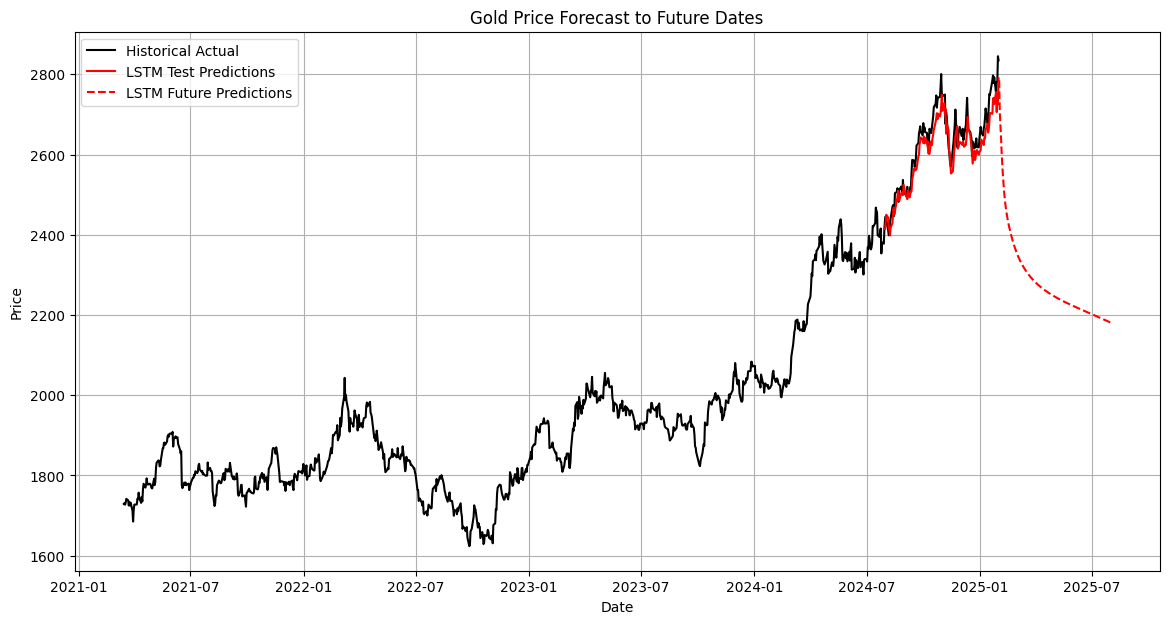

In [5]:
import pandas as pd
import numpy as np
import torch

def predict_future(model, initial_window, future_start_date, future_end_date, scaler, device, window_width=30):
    """
    Predict future gold prices day-by-day beyond the existing dataset.

    Args:
        model (nn.Module): Your trained PyTorch model.
        initial_window (np.ndarray): Last 30 days of scaled input data (shape: (30, num_features)).
        future_start_date (str or pd.Timestamp): Start date for future predictions (e.g., '2025-02-01').
        future_end_date (str or pd.Timestamp): End date for future predictions (e.g., '2025-07-31').
        scaler (MinMaxScaler): Fitted scaler used for your training data.
        device: torch.device to run predictions on (CPU/GPU).
        window_width (int): Number of past days each prediction window uses (30 by default).
        
    Returns:
        future_dates (pd.DatetimeIndex): Index of future prediction dates.
        future_preds_inv (np.ndarray): Inverse-transformed array of predicted future prices.
    """
    # Create a date range for your future predictions
    future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='D')
    num_future_days = len(future_dates)
    
    # Convert initial_window to the shape (1, window_width, num_features)
    # This is your “seed” data: the last 30 days of *scaled* features before future_start_date
    current_window = np.array(initial_window).reshape(1, window_width, -1)
    
    # Send the window to the same device as your model
    current_window_torch = torch.from_numpy(current_window).float().to(device)
    
    future_preds_scaled = []  # store scaled predictions
    
    # Day-by-day forecasts
    model.eval()
    with torch.no_grad():
        for _ in range(num_future_days):
            # Predict next day
            y_pred_scaled = model(current_window_torch)  # shape: (1, 1)
            future_preds_scaled.append(y_pred_scaled.cpu().numpy().flatten()[0])
            
            # Update the window
            # 1) Remove the oldest day (index 0)
            # 2) Append the new predicted day’s features (here, we do a univariate example, so repeat the predicted price for all features or adapt as needed)
            new_day_scaled = np.array([y_pred_scaled.cpu().numpy().flatten()[0]] * current_window.shape[2])
            new_day_scaled = new_day_scaled.reshape(1, 1, -1)
            
            # Shift left by 1 day, then add new day at the end
            current_window_torch = torch.cat([current_window_torch[:, 1:, :], torch.tensor(new_day_scaled, dtype=torch.float, device=device)], dim=1)

    # Inverse-transform the predicted values
    future_preds_scaled = np.array(future_preds_scaled).reshape(-1, 1)
    # If you are only tracking “Price” in your scaled array, you can inverse using your custom function
    future_preds_inv = []
    for val in future_preds_scaled:
        # Reuse your existing inverse_transform function if it expects shape (N, 1), plus zeroes for other features
        inv = inverse_transform(val)  # e.g., from your code snippet
        future_preds_inv.append(inv)
    future_preds_inv = np.array(future_preds_inv).flatten()

    return future_dates, future_preds_inv


# ---------------------------
# Usage Example:

# 1) Train your model with train_and_evaluate(...)
#    Suppose 'best_model' is the chosen model loaded from the best checkpoint:


# 1) Load the best model
model = BaseModel(model_type='LSTM').to(device)
model.load_state_dict(torch.load('best_model_LSTM_3yr.pt', map_location=device))

# 2) Fix the seed window extraction
#    Use the *last single sequence* from X, not the last 30 sequences.
initial_window = X[-1]  # Now shape: (30,4)
initial_window = initial_window.reshape(1, 30, 4)  # shape: (1,30,4)

# 3) Predict future
future_start = '2025-02-01'
future_end = '2025-07-31'
future_dates, future_predictions = predict_future(
    model=model,
    initial_window=initial_window,
    future_start_date=future_start,
    future_end_date=future_end,
    scaler=scaler,
    device=device,
    window_width=30
)



# 4) Plot the future predictions with your existing chart
plt.figure(figsize=(14, 7))

# Plot full historical actual prices
plt.plot(dates, inverse_transform(y), label='Historical Actual', color='black')

# Plot your model’s test predictions (already generated) ...
plt.plot(all_results['LSTM']['test_dates'], all_results['LSTM']['y_test_pred_inv'], 
         label='LSTM Test Predictions', color='red')

# Now append future predictions
plt.plot(future_dates, future_predictions, label='LSTM Future Predictions', color='red', linestyle='--')

plt.title('Gold Price Forecast to Future Dates')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_1016168/2083512457.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))
/tmp/ipykerne

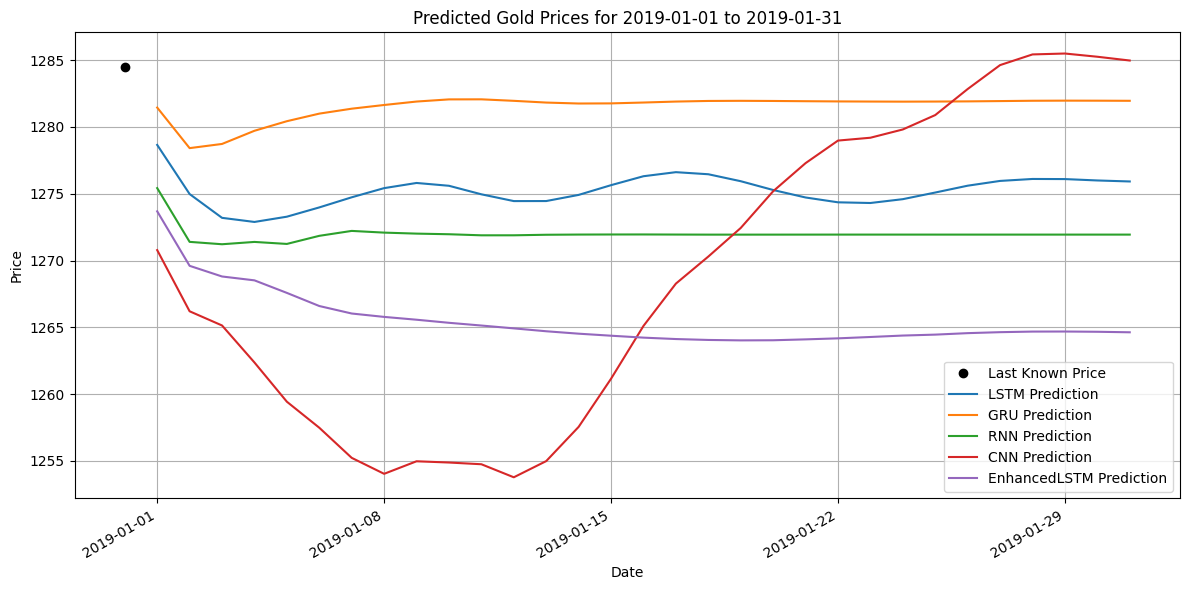

In [4]:
def forecast_future_prices(model, data_scaled, last_date, start_date, end_date, scaler, window_width=30):
    """
    Iteratively predict future prices from 'start_date' to 'end_date'
    using the trained 'model' and the last 'window_width' days of known data.
    
    Parameters:
        model (nn.Module): Trained PyTorch model.
        data_scaled (np.ndarray): Full scaled data (2D array) up to the last known day.
        last_date (pd.Timestamp): The final known date in data_scaled.
        start_date (str or pd.Timestamp): Start date of forecast period.
        end_date (str or pd.Timestamp): End date of forecast period.
        scaler (MinMaxScaler): Fitted MinMaxScaler used on the original dataset.
        window_width (int): Window length used during training.
        
    Returns:
        future_dates (list of pd.Timestamp): List of future dates predicted.
        future_preds_inv (np.ndarray): Inverse-scaled predictions for each future date.
    """
    
    # Convert string to pd.Timestamp if needed
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Generate a list of all future days you want to predict
    future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    num_future_days = len(future_dates)

    # Prepare the initial sequence (last 30 days) from the known dataset
    # We'll assume the last 'window_width' rows in data_scaled correspond to the last_date
    # Make sure your data's final row's date actually matches `last_date`.
    last_sequence = data_scaled[-window_width:].copy()

    model.eval()
    predictions_scaled = []

    for day_idx in range(num_future_days):
        # Convert the last_sequence into a torch tensor
        seq_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_scaled = model(seq_tensor)  # shape: [batch_size=1, 1]
        
        # Extract the predicted scaled price (float)
        pred_scaled_price = pred_scaled.item()
        predictions_scaled.append(pred_scaled_price)
        
        # ============ Shift Window Forward ============
        # Option A: Naively reuse the predicted price for "Price" column,
        #           and keep the last known values for 'Open', 'High', 'Low'.
        #           This is only approximate because we don't truly know future Open/High/Low.
        
        # Reshape for easy indexing: last_sequence shape is [window_width, num_features]
        new_row = last_sequence[-1].copy()  # Start from the last known day’s feature row
        new_row[0] = pred_scaled_price      # Replace Price with the newly predicted price
        # If you want to handle Open/High/Low differently, adjust here.
        
        # Now roll the window up by 1 and put the new_row at the end
        last_sequence = np.roll(last_sequence, -1, axis=0)
        last_sequence[-1] = new_row

    # Inverse-transform the scaled predictions into real price
    predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
    # Combine with zeros for the other 3 features (Open, High, Low) if your scaler expects 4 columns
    zeros = np.zeros((predictions_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((predictions_scaled, zeros))
    future_preds_inv = scaler.inverse_transform(y_combined)[:, 0]

    return future_dates, future_preds_inv


# ============== FUTURE PREDICTIONS AND PLOTTING ==============
# We assume your test set last date is around 2018-12-31
# (or the last known date in 'df' is 2018-12-31).

# Identify the last known date in your dataset:
last_known_date = df['Date'].iloc[-1]  # e.g., 2018-12-31

# We will forecast from 2019-01-01 to 2019-01-31
forecast_start = '2019-01-01'
forecast_end   = '2019-01-31'

plt.figure(figsize=(12, 6))
plt.title('Predicted Gold Prices for 2019-01-01 to 2019-01-31')
plt.xlabel('Date')
plt.ylabel('Price')

# Plot a marker at the last known actual price:
last_actual_price = df['Price'].iloc[-1]
plt.plot([last_known_date], [last_actual_price], 'ko', label='Last Known Price')

# Dictionary to store each model's future predictions for possible further analysis
future_predictions = {}

for model_name in model_names:
    # Re-initialize the same architecture
    model = BaseModel(model_type=model_name).to(device)
    
    # Load best saved weights
    best_model_path = f'best_model_{model_name}.pt'
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # Forecast
    future_dates, future_preds = forecast_future_prices(
        model=model,
        data_scaled=data_scaled,
        last_date=last_known_date,
        start_date=forecast_start,
        end_date=forecast_end,
        scaler=scaler,
        window_width=window_width
    )
    
    future_predictions[model_name] = (future_dates, future_preds)
    
    # Plot the predictions
    plt.plot(future_dates, future_preds, label=f'{model_name} Prediction')

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Now 'future_predictions' holds each model's date range and predicted prices.


/tmp/ipykernel_1016168/759521126.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))
/tmp/ipykernel_

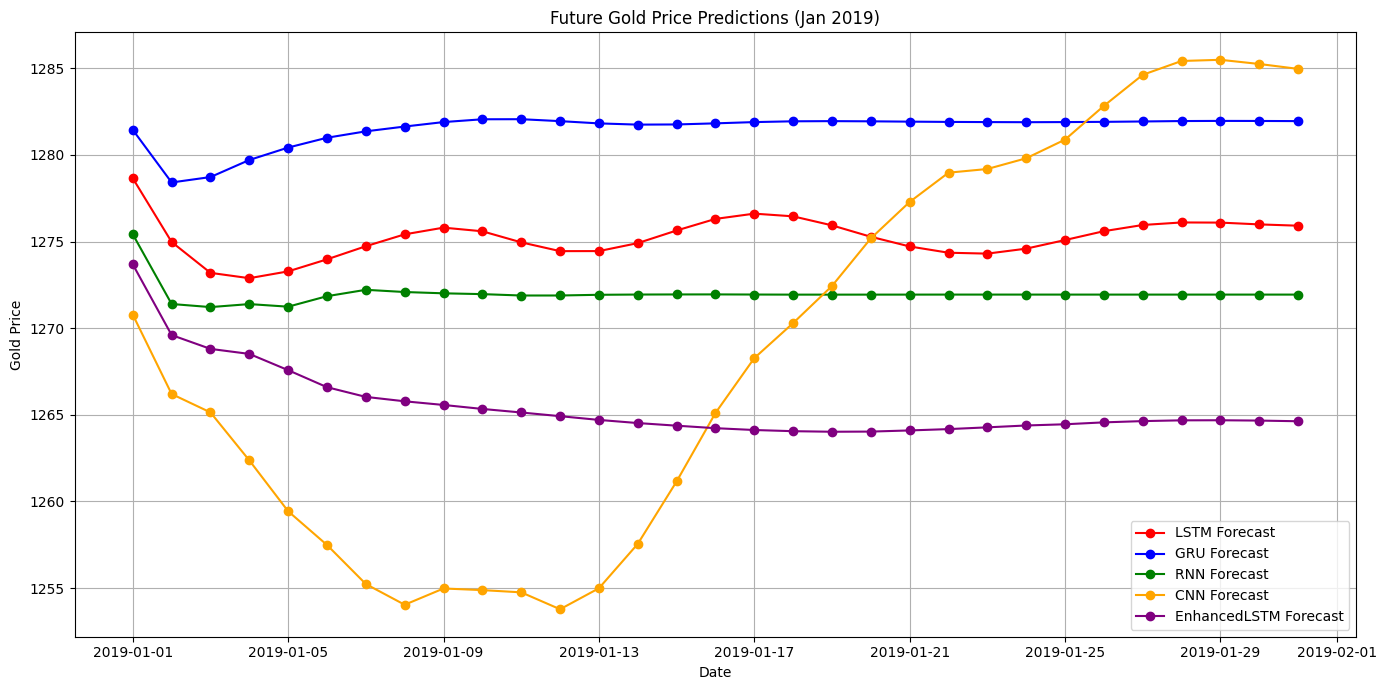

In [3]:
###############################################
# Future Prediction: Forecasting Gold Price
# for the period 2019-01-01 to 2019-01-31
###############################################

# Dictionary to store the forecasted prices (in original scale) for each model
future_forecasts = {}

# Define the forecast period: January 1 to January 31, 2019
future_dates = pd.date_range(start='2019-01-01', end='2019-01-31', freq='D')

# For each model, load the saved best checkpoint and perform iterative forecasting
for model_name in model_names:
    # Initialize the model and load the best saved weights
    model = BaseModel(model_type=model_name).to(device)
    best_model_path = f'best_model_{model_name}.pt'
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    
    # Start with the last available window from the entire historical dataset
    # (Make a copy so that the original data_scaled remains unchanged)
    forecast_window = data_scaled[-window_width:].copy()  # shape: (window_width, n_features)
    
    # List to store the scaled predictions (for the target 'Price')
    forecast_preds = []
    
    # Disable gradient tracking for forecasting
    with torch.no_grad():
        # Iterate for each day in the forecast period (31 days)
        for _ in range(len(future_dates)):
            # Prepare the input: add batch dimension (shape: [1, window_width, n_features])
            input_tensor = torch.from_numpy(forecast_window).unsqueeze(0).float().to(device)
            
            # Obtain the prediction (scaled price)
            pred = model(input_tensor)
            pred_value = pred.item()  # scalar value
            
            # Append the predicted scaled price to our list
            forecast_preds.append(pred_value)
            
            # Update the forecast window:
            # Create a new row based on the last row of the current window.
            # Replace only the 'Price' column (index 0) with the predicted value.
            new_row = forecast_window[-1].copy()
            new_row[0] = pred_value
            # Roll the window: remove the oldest row and append the new row at the end
            forecast_window = np.vstack((forecast_window[1:], new_row))
    
    # Inverse transform the list of scaled predictions back to the original scale.
    # (The inverse_transform function only uses the first column, so it works for our list.)
    forecast_preds_inv = inverse_transform(forecast_preds)
    
    # Store the forecasted prices for this model
    future_forecasts[model_name] = forecast_preds_inv

# Plot the future forecasted prices for each model
plt.figure(figsize=(14, 7))
for model_name, preds in future_forecasts.items():
    plt.plot(future_dates, preds, color=model_colors[model_name], linestyle='-', marker='o',
             label=f'{model_name} Forecast')

plt.title('Future Gold Price Predictions (Jan 2019)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1016168/1552756690.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  future_model.load_state_dict(torch.load(best_model_path, map_location=device))


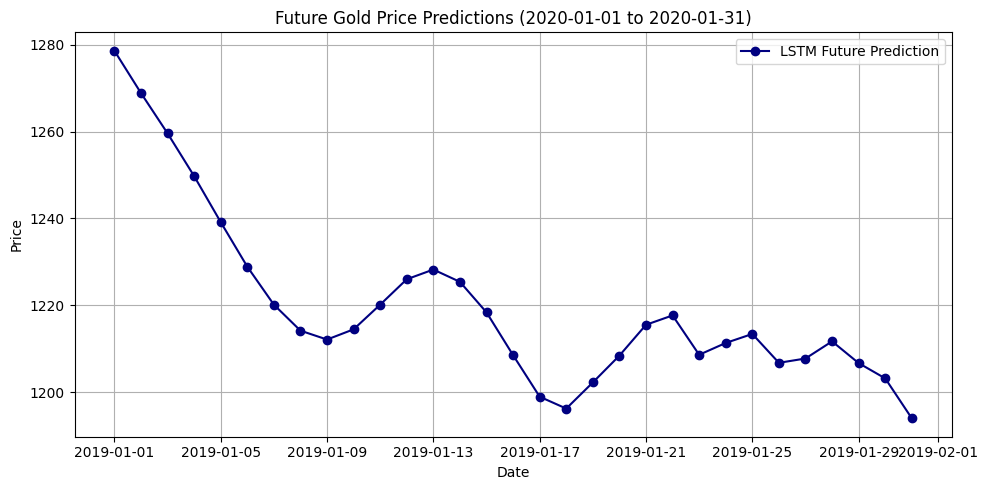

         Date  Predicted Price
0  2019-01-01      1278.654784
1  2019-01-02      1268.891180
2  2019-01-03      1259.614430
3  2019-01-04      1249.757114
4  2019-01-05      1239.153828
5  2019-01-06      1228.883743
6  2019-01-07      1220.127108
7  2019-01-08      1214.140468
8  2019-01-09      1212.092611
9  2019-01-10      1214.447813
10 2019-01-11      1220.138146
11 2019-01-12      1225.989377
12 2019-01-13      1228.223902
13 2019-01-14      1225.387136
14 2019-01-15      1218.350639
15 2019-01-16      1208.487197
16 2019-01-17      1198.917020
17 2019-01-18      1196.183732
18 2019-01-19      1202.208063
19 2019-01-20      1208.395549
20 2019-01-21      1215.495852
21 2019-01-22      1217.652994
22 2019-01-23      1208.581221
23 2019-01-24      1211.306849
24 2019-01-25      1213.379664
25 2019-01-26      1206.731009
26 2019-01-27      1207.722706
27 2019-01-28      1211.673069
28 2019-01-29      1206.660913
29 2019-01-30      1203.141854
30 2019-01-31      1193.933780


In [2]:
# ------------------------------
# Future Prediction: 2020-01-01 to 2020-01-31
# ------------------------------

# Choose the model to use for forecasting (e.g., 'LSTM')
future_model_name = 'LSTM'
best_model_path = f'best_model_{future_model_name}.pt'

# Initialize and load the trained model
future_model = BaseModel(model_type=future_model_name).to(device)
future_model.load_state_dict(torch.load(best_model_path, map_location=device))
future_model.eval()

# Create a date range for the future period
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2019-01-31')
future_dates = pd.date_range(start_date, end_date)

# Use the last available window from the scaled data as the starting point
# Note: 'data_scaled' is from the full dataset used in training
current_window = data_scaled[-window_width:].copy()  # shape: (window_width, num_features)

future_predictions_scaled = []  # To store the model's scaled predictions

# Rolling forecast: predict one day ahead at a time
for future_date in future_dates:
    # Prepare the current window as input (add batch dimension)
    input_tensor = torch.from_numpy(current_window).float().unsqueeze(0).to(device)  # shape: (1, window_width, num_features)
    
    with torch.no_grad():
        pred_scaled = future_model(input_tensor).cpu().numpy()[0, 0]  # Get scalar prediction
    future_predictions_scaled.append(pred_scaled)
    
    # Create a new row for the predicted day.
    # Since the model was trained on 4 features, we fill Open, High, Low with the same value as Price.
    new_row = np.array([pred_scaled, pred_scaled, pred_scaled, pred_scaled])
    
    # Append the new prediction to the window and drop the oldest row to maintain the window length
    current_window = np.vstack([current_window[1:], new_row])

# Inverse transform the scaled predictions back to the original price scale
future_predictions = inverse_transform(future_predictions_scaled)

# Plot the future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_predictions, marker='o', linestyle='-', color='navy', label=f'{future_model_name} Future Prediction')
plt.title('Future Gold Price Predictions (2020-01-01 to 2020-01-31)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the predictions as a DataFrame
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions})
print(future_df)
